<a href="https://colab.research.google.com/github/mbron64/CS550_Lab4/blob/main/cs480e_2024%2C3f_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS480E/580E: Final Exam





Name: Michael Bronikowski

B-number: B00808654

E-mail: mbronik1@binghamton.edu

## General Instructions
### Due December 13th, 11:59 PM.

In the final exam, you will use autoencoders to do dimensionality reduction on the MNIST images. You will then use the reduced dimensional representations to perform similarity search on test images. At the end of notebook, you will be able to retrieve k-most similar images on the training set.  


Functions and cells that need to be implemented are marked with a bold **implement** keyword or clearly marked in the experiments section.

Make sure to **run** the cells marked for running to make sure all the data and functions are available.

The GitHub link is here: https://classroom.github.com/a/PQyT1LP2. You must have 15 commits for this.

**AI is not allowed for this final.**
This is in an intro course,
so we want you to learn the fundamentals first.
Maybe in 10 years that will change,
but we are not there yet.

**Run** the following cell to import libraries.

In [2]:
import math
import random
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

%matplotlib inline


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Dataset

You will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9).

To simplify our code here, use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`.

**Run** the following cell to mount your drive on colab.

In [3]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Run** the following cells to retrieve the MNIST training, validation, and test sets

In [4]:
mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())

mnist_test = dset.MNIST('./MNIST_data', train=False, download=True,
                        transform=T.ToTensor())

mnist_train, mnist_validation = random_split(mnist_train, [.8, .2])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.23MB/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



**Run** this cell to print the number of cells on the traning, validation, and test datasets.

In [5]:
print(len(mnist_train), len(mnist_validation), len(mnist_test))

48000 12000 10000


**Run** this cell to define the helper function to generate grids of images.

In [6]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

**Implement** the following cell to define a `batch_size`, `loader_train`, and `loader_validation`.

`batch_size` should be an integer value that defines the number of samples per mini-batch that will be used for the training dataloader.

`loader_train` should be a PyTorch DataLoader on the `mnist_train` dataset with `batch_size = batch_size`, `shuffle` enabled and drop the last mini-batch.

`loader_validation` should be a PyTorch DataLoader on the `mnist_validation` dataset. Set the `batch_size` as high as possible for this.

In [19]:
# ==== BEGIN SOLUTION CODE ====
batch_size = 1000

loader_train = DataLoader(
    mnist_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

loader_validation = DataLoader(
    mnist_validation,
    batch_size=len(mnist_validation),
    shuffle=False,
    drop_last=False
)

# ==== END SOLUTION CODE ====

**Run** the following cell to show an example of a grid of MNIST images.

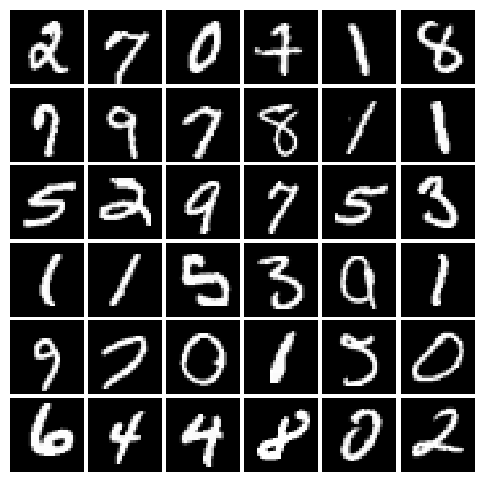

In [8]:
imgs = next(iter(loader_train))[0].view(batch_size, 784)
show_images(imgs[:36])

# (Part 1) Autoencoder - 100 pts

In the next cell, **implement** the definition of the `AutoEncoder` class, that implements an autoencoder using convolutions, transpose convolutions, fully connected and non-linear activation layers.



You are free to choose any architecture you would like.
**But your network must use at least 1 convolution layer**


Complete the following methods:

- `__init__(height, width, latent_dim)`: Initializes the desired layer and architecture.
  - The inputs to the class constructor are:
    - `height`: The height of the input images
    - `width`: The width of the input images
    - `latent_dim`: The size of the latent vector
- `encode(x)`: Encodes a batch of images `x` to a batch of latent vectors, `h`
- `decode(h)`: Decodes a batch of latent vectors `h` to a batch images, `x_reconstructed`
- `forward(x)`: Uses `encode` and `decode` method to compress and reconstruct a batch of images, `x`.

In [37]:
class AutoEncoder(nn.Module):
    def __init__(self, height, width, latent_dim):
        """
        """
        super().__init__()

        conv_height = height // 4  # After 2 stride-2 convolutions: 28->14->7
        conv_width = width // 4    # After 2 stride-2 convolutions: 28->14->7

        # Calculate flattened dimension after convolutions
        flattened_size = 32 * conv_height * conv_width

        # Encoder network
        self.encoder = nn.Sequential(
            # First conv block: 1->16 channels
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # Second conv block: 16->32 channels
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # Flatten layer
            nn.Flatten(),

            # Fully connected to latent space
            nn.Linear(flattened_size, latent_dim)
        )

        # Decoder network
        self.decoder = nn.Sequential(
            # Fully connected from latent space
            nn.Linear(latent_dim, flattened_size),
            nn.ReLU(),

            # Reshape back to 3D tensor
            nn.Unflatten(1, (32, conv_height, conv_width)),

            # First transpose conv: 32->16 channels
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            # Second transpose conv: 16->1 channels
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Sigmoid to get values between 0 and 1
        )

        # ==== END SOLUTION CODE ====

    def encode(self, x):
        """
        """
        h = None
        # ==== BEGIN SOLUTION CODE ====
        h = self.encoder(x)
        # ==== END SOLUTION CODE ====
        return h

    def decode(self, h):
        """
        """
        x_reconstructed = None
        # ==== BEGIN SOLUTION CODE ====
        x_reconstructed = self.decoder(h)
        # ==== END SOLUTION CODE ====
        return x_reconstructed

    def forward(self, x):
        """
        """
        x_reconstructed = None
        # ==== BEGIN SOLUTION CODE ====
        x_reconstructed = self.decode(self.encode(x))
        # ==== END SOLUTION CODE ====
        return x_reconstructed

## Autoencoder Training (60 pts)

In the following cell, define an autoencoder (AE) and train on the training set.

The AE training algorithm is as follows:

1. Instantiate an `AutoEncoder`. Set it to the `model` variable.
2. Define a dataloader in order to do mini-batch training. Batch size is up to you. (You should have done this in above cells.)
3. Define an optimizer for your AE
4. For each batch of data in `loader_train`:
    - Pass the input through the AE to get the reconstructed input
    - Calculate the loss using the [`nn.functional.binary_cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html)
    - Zero the gradients, propagate the loss backwards, and update the  weights using the optimizer

5. Repeat 4
6. After N iterations (or every epoch), compute the validation loss over the validation set (using the `loader_validation`).


In [40]:
model = None # Instantiate your model to this variable

# ==== BEGIN SOLUTION CODE ====
# Hyperparameters
latent_dim = 32
num_epochs = 10
learning_rate = 0.001

# Initialize model
model = AutoEncoder(height=28, width=28, latent_dim=latent_dim)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    # Training phase
    for batch_idx, (data, _) in enumerate(loader_train):
        # Forward pass
        reconstructed = model(data)
        loss = nn.functional.binary_cross_entropy(reconstructed, data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
        num_batches += 1

    # Average training loss for epoch
    avg_train_loss = epoch_loss / num_batches

    # Validation phase
    model.eval()
    val_loss = 0.0
    num_val_batches = 0

    with torch.no_grad():
        for val_data, _ in loader_validation:
            # Forward pass
            val_reconstructed = model(val_data)
            val_loss += nn.functional.binary_cross_entropy(val_reconstructed, val_data).item()
            num_val_batches += 1

    # Calculate average validation loss
    avg_val_loss = val_loss / num_val_batches

    # Progress
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print('-' * 50)

# ==== END SOLUTION CODE ====
assert model is not None

Epoch [1/10]
Training Loss: 0.4207
Validation Loss: 0.2731
--------------------------------------------------
Epoch [2/10]
Training Loss: 0.2661
Validation Loss: 0.2610
--------------------------------------------------
Epoch [3/10]
Training Loss: 0.2555
Validation Loss: 0.2460
--------------------------------------------------
Epoch [4/10]
Training Loss: 0.2257
Validation Loss: 0.1956
--------------------------------------------------
Epoch [5/10]
Training Loss: 0.1658
Validation Loss: 0.1406
--------------------------------------------------
Epoch [6/10]
Training Loss: 0.1263
Validation Loss: 0.1165
--------------------------------------------------
Epoch [7/10]
Training Loss: 0.1107
Validation Loss: 0.1066
--------------------------------------------------
Epoch [8/10]
Training Loss: 0.1033
Validation Loss: 0.1009
--------------------------------------------------
Epoch [9/10]
Training Loss: 0.0987
Validation Loss: 0.0971
--------------------------------------------------
Epoch [10/

**Implement** the following cell to generate 36 random reconstructions from your previously trained AE model and visualize the outputs.

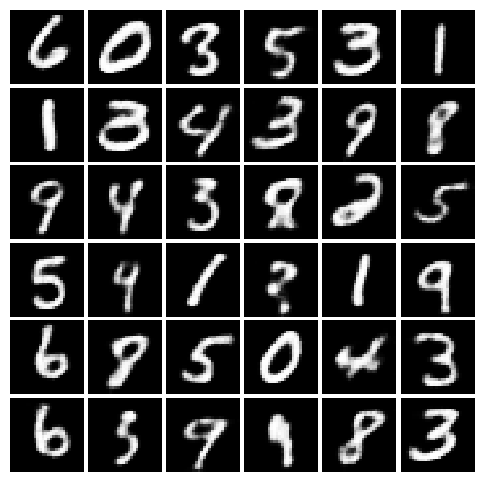

In [44]:
# ==== BEGIN SOLUTION CODE ====

# A batch of images from the training set
data_iter = iter(loader_train)  # Assuming loader_train is defined
images, _ = next(data_iter)

# 36 random images from the batch
num_reconstructions = 36
random_indices = random.sample(range(len(images)), num_reconstructions)
random_images = images[random_indices]

# Reconstructing images
model.eval()
with torch.no_grad():
    reconstructions = model(random_images)

# Plot
show_images(reconstructions)

# ==== END SOLUTION CODE ====

## Masked Autoencoder Training (40 pts)

Masked autoencoders (MAE) are autoencoder models trained with corrupted images via masking out random pixel values to 0.

In the following cell, define a masked autoencoder (MAE) and train on the training set.

The MAE training algorithm is as follows:

1. Instantiate an `AutoEncoder`. Set it to the `mae_model` variable
2. Define an optimizer for your MAE
3. For each `batch` of data in `loader_train`:
    - Get the (image, label) tuple. You can discard the label.
    - Get the `masked_image` by using the `random_mask` function given below.
    - Pass the masked input, `masked_image` through the MAE to get the reconstructed input
    - Calculate the loss using the [`nn.functional.binary_cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html). The loss should be calculated between the reconstructed image (the output of the model) and the original unmasked image.
    - Zero the gradients, propagate the loss backwards, and update the  weights using the optimizer

4. Repeat 3
5. After N iterations (or every epoch), compute the validation loss over the validation set (using the `loader_validation`).

**Note** This is a more difficult learning task compared to regular autoencoder training, so you will have update hyperparameters to get good results

*Run* the following cell to show an example of a grid of MNIST images that have been masked.

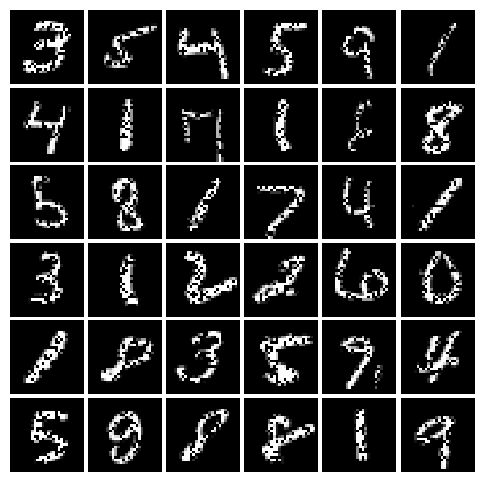

In [42]:
def random_mask(image_batch, mask_percent=0.3):
    '''Takes a batch of images and masks random pixels'''
    assert len(image_batch.shape) == 4, "Expected a batch of images."
    copy_batch = image_batch.clone()
    device = image_batch.device
    orig_shape = image_batch.shape
    num_elem = torch.numel(image_batch)

    non_zero_pixels = torch.argwhere(copy_batch.view(-1) > 0)
    num_non_zero = non_zero_pixels.shape[0]
    mask_num = int(num_non_zero * mask_percent)

    permute = torch.randperm(num_non_zero)
    mask_pixels = non_zero_pixels[permute[:mask_num]]

    copy_batch = copy_batch.view(-1)
    copy_batch[mask_pixels] = 0
    copy_batch = copy_batch.view(orig_shape)
    return copy_batch

imgs = next(iter(loader_train))[0]
masked_imgs = random_mask(imgs).view(batch_size, 784)
show_images(masked_imgs[:36])

In [43]:
mae_model = None # Instantiate your model to this variable

# ==== BEGIN SOLUTION CODE ====

# Hyperparameters
latent_dim = 64  # Increased latent dimension
num_epochs = 30  # More epochs
learning_rate = 0.0005  # Lower learning rate
mask_percent = 0.3  # Masking percentage

# Initialize model and optimizer
mae_model = AutoEncoder(height=28, width=28, latent_dim=latent_dim)
optimizer = optim.Adam(mae_model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
val_losses = []
# Training loop
for epoch in range(num_epochs):
    mae_model.train()
    epoch_loss = 0.0
    num_batches = 0

    # Training phase
    for batch_idx, (data, _) in enumerate(loader_train):
        # Create masked version of input
        masked_data = random_mask(data, mask_percent)

        # Forward pass with masked input
        reconstructed = mae_model(masked_data)

        # Calculate loss between reconstruction and original unmasked image
        loss = nn.functional.binary_cross_entropy(reconstructed, data)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_train_loss = epoch_loss / num_batches
    train_losses.append(avg_train_loss)
    # Validation phase
    mae_model.eval()
    val_loss = 0.0
    num_val_batches = 0

    with torch.no_grad():
        for val_data, _ in loader_validation:
            # Create masked version of validation data
            masked_val_data = random_mask(val_data, mask_percent)

            # Forward pass
            val_reconstructed = mae_model(masked_val_data)

            # Calculate validation loss with original unmasked data
            val_loss += nn.functional.binary_cross_entropy(val_reconstructed, val_data).item()
            num_val_batches += 1

    avg_val_loss = val_loss / num_val_batches
    val_losses.append(avg_val_loss)

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print('-' * 50)


# ==== END SOLUTION CODE ====
assert mae_model is not None

Epoch [5/30]
Training Loss: 0.2369
Validation Loss: 0.2207
--------------------------------------------------
Epoch [10/30]
Training Loss: 0.1164
Validation Loss: 0.1133
--------------------------------------------------
Epoch [15/30]
Training Loss: 0.0987
Validation Loss: 0.0980
--------------------------------------------------
Epoch [20/30]
Training Loss: 0.0924
Validation Loss: 0.0922
--------------------------------------------------
Epoch [25/30]
Training Loss: 0.0888
Validation Loss: 0.0887
--------------------------------------------------
Epoch [30/30]
Training Loss: 0.0863
Validation Loss: 0.0862
--------------------------------------------------


**Implement** the following cell to generate 36 random reconstructions from your previously trained MAE model and visualize the outputs.

In [ ]:
# ==== BEGIN SOLUTION CODE ====
# Get a batch of images from the training set
data_iter = iter(loader_train)
images, _ = next(data_iter)

# Select 36 random images from the batch
num_reconstructions = 36
random_indices = random.sample(range(len(images)), num_reconstructions)
random_images = images[random_indices]

# Apply random masking to the images
masked_images = random_mask(random_images, mask_percent)  # Use mask_percent from training

# Reconstruct the images using the trained MAE model
mae_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    reconstructions = mae_model(masked_images)

# Visualize the original, masked, and reconstructed images
show_images(reconstructions)
# ==== END SOLUTION CODE ====

# (Part 2, 40 pts Extra Credit) Similarity Search

Now using your trained model, you will generate latent vectors of the training images. This will encode the images into a vector.

You will also use your trained models to encode a test image into a vector, compute a similarity measure ($L_2$ or Cosine-similarity) with the training latent vectors.

**Implement** the following cell to complete the `generate_latent_vectors` function.

The arguments are:

- `model`: The model used to generate the latent encodings
- `dataset`: The dataset to the generate the latent encodings

Returns:
- PyTorch tensor of latent vectors computed from the dataset images using the model. It should be a 2D tensor with `len(dataset)` rows and `latent_dim` columns.

Iterate over each image in the `dataset` and `encode` the images using the `model`. Make sure to turn off backprop and gradient calculations using `with torch.no_grad()` and set the model to evaluation mode using `model.eval()`.

You may find the `torch.vstack` function useful.

Also, your code may be written to expect a batch dimension such that images are
(num_samples, 1, 28, 28), so you may have to use `.unsqueeze(0)` to convert a single image to a batch of images with a single image.


In [45]:
def generate_latent_vectors(model, dataset):
    '''
    Iterates over the dataset and uses the model to generates latent vectors.
    Returns a Torch tensor of latent vectors of shape

    Args:
      - model : trained model
      - dataset: PyTorch dataset of images

    Returns:
      - latent_vectors - Torch tensor of dimension (len(dataset), latent_dim).
    '''
    latent_vectors = None
    # ==== BEGIN SOLUTION CODE ====
    model.eval()

    # List to store latent vectors
    latent_list = []

    # Disable gradient
    with torch.no_grad():

        for i in range(len(dataset)):
            # Get image and add batch dimension
            img, _ = dataset[i]
            img = img.unsqueeze(0)  # Add batch dimension (1, 1, 28, 28)

            # Generate latent vector
            latent = model.encode(img)
            latent_list.append(latent)

    # Stack all latent vectors into a tensor
    latent_vectors = torch.vstack(latent_list)

    # ==== END SOLUTION CODE ====
    return latent_vectors

**Run** the following cell to generate the latent vectors of the images from the `mnist_train` dataset using your `model` and the `generate_latent_vectors` dataset.

In [47]:
training_vectors = generate_latent_vectors(model, mnist_train)
mae_training_vectors = generate_latent_vectors(mae_model, mnist_train)

**Implement** the `cosine_sim` function that computes the cosine similarity between each row of input tensors `a` and `b` and the 1-D tensor of indices with the of the `k` closest values.


*Hint: You can use the [torch.nn.functional.cosine_similarity](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html#torch.nn.functional.cosine_similarity) and
[torch.topk](https://pytorch.org/docs/stable/generated/torch.topk.html) functions. Make sure you use the appropriate parameters*  

In [57]:
def cosine_sim(a, b, k=5):
    # ==== BEGIN SOLUTION CODE ====
      # Compute Cosine Sim
      similarities = nn.functional.cosine_similarity(a.unsqueeze(0), b, dim=1)
      # Indices of k largest similarities
      _, ind = torch.topk(similarities, k=k, largest=True)
      return ind

    # ==== END SOLUTION CODE ====

**Implement** the `l2_pairwise_dist` function that computes the l2 distance between each row of input tensors `a` and `b` and returns the 1-D tensor of indices with the of the `k` closest values.

*Hint: You can use the [torch.nn.functional.pairwise_distance](https://pytorch.org/docs/stable/generated/torch.nn.functional.pairwise_distance.html#torch.nn.functional.pairwise_distance) and
[torch.topk](https://pytorch.org/docs/stable/generated/torch.topk.html) functions. Make sure you use the appropriate parameters*

In [58]:
def l2_pairwise_dist(a, b, k=5):
    # ==== BEGIN SOLUTION CODE ====
    #Compute L2 distances
    distances = nn.functional.pairwise_distance(a.unsqueeze(0), b, p=2)

    # Indices of k smallest distances
    _, ind = torch.topk(distances, k=k, largest=False)

    # ==== END SOLUTION CODE ====

**Implement** the following function to find the top-k most similar images for a given image using a given 2-D array of latent vectors.

The arguments are:
  - `img`: The image to search similar images for.
  - `model`: The trained model to use to generate latent vector of `img`.
  - `latents`: The 2D tensor of latent vectors of the training dataset. Find the similar vectors to `img`s latent vector within this 2D tensor.
  - `k`: The number of indices to return (default: 5)
  - `distance_function`: The distance function to use to measure the similarity between latent vectors.  
  

Returns:
    - The 1-D tensor of indices of the similar images to `img`


Get the latent vector of `img` using your `model`s `encode` and then use the `distance_function` to get the `k`-nearest vectors.

In [59]:
def find_top_k(img, model, latents, k = 5, distance_function=cosine_sim):
    ind = None
    # ==== BEGIN SOLUTION CODE ====
    model.eval()

    # Get latent vector for input image
    with torch.no_grad():
        # Add batch dimension if needed
        if len(img.shape) == 3:
            img = img.unsqueeze(0)

        # Encode image
        img_latent = model.encode(img)

        # Remove batch dimension
        img_latent = img_latent.squeeze(0)

    # Find k most similar vectors
    ind = distance_function(img_latent, latents, k)

    # ==== END SOLUTION CODE ====
    return ind

**Run** the following cell to define the top-k image visualization helper function.

In [60]:
def show_top_k_images(root_image, images):

    num_images = len(images) + 1
    sqrtimg = int(math.ceil(math.sqrt(28)))

    fig = plt.figure(figsize=(num_images*2.5, num_images*5))
    gs = gridspec.GridSpec(1, num_images)
    gs.update(wspace=0.05, hspace=0.05)
    images = [root_image] + images

    for i, img in enumerate(images):

        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([28, 28]))
        if i == 0:
            ax.set_title("Search Image")
    return

**Run** the following cell to get the 5 most similar images to an image from the test set using a cosine similarity metric.

If all the above cells are completed correctly, there should be no errors, and the found images should look visually similar.

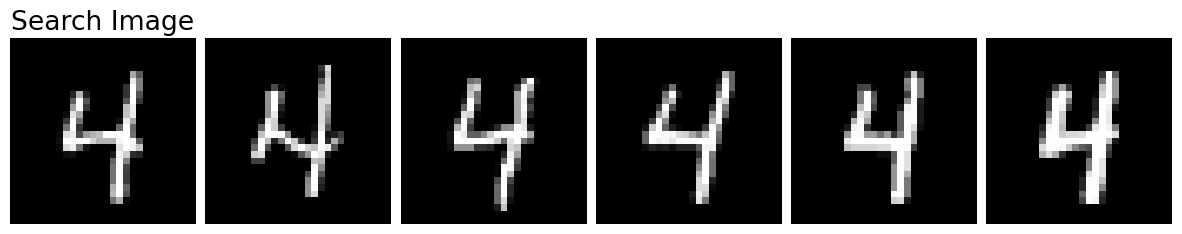

In [61]:
root_img_ind = 19
root_img = mnist_test[root_img_ind][0]
_inds = find_top_k(root_img, model, training_vectors, k=5, distance_function= cosine_sim)
images = []
for i in _inds:
    images.append(mnist_train[i][0])
show_top_k_images(root_img, images)

**Run** the following cell to get the 5 most similar images to an image from the test set using a cosine similarity metric using the MAE.

If all the above cells are completed correctly, there should be no errors, and the found images should look visually similar.

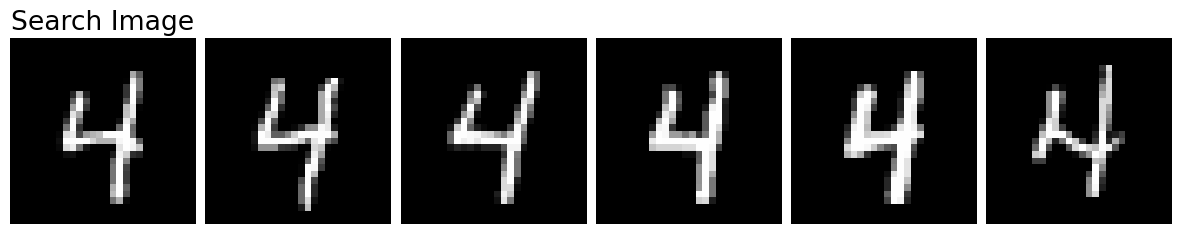

In [63]:
root_img_ind = 19
root_img = mnist_test[root_img_ind][0]
_inds = find_top_k(root_img, mae_model, mae_training_vectors, k=5, distance_function=cosine_sim)
images = []
for i in _inds:
    images.append(mnist_train[i][0])
show_top_k_images(root_img, images)

**Run** the following cell to get the 5 most similar images to an image from the test set using a $\mathcal{l}_2$ distance.


If all the above cells are completed correctly, there should be no errors, and the found images should look visually similar.

In [64]:
root_img_ind = 19
root_img = mnist_test[root_img_ind][0]
_inds = find_top_k(root_img, model, training_vectors, k=5, distance_function=l2_pairwise_dist)
images = []
for i in _inds:
    images.append(mnist_train[i][0])
show_top_k_images(root_img, images)

TypeError: 'NoneType' object is not iterable

**Run** the following cell to get the 5 most similar images to an image from the test set using a $\mathcal{l}_2$ distance using the MAE.


If all the above cells are completed correctly, there should be no errors, and the found images should look visually similar.

In [ ]:
root_img_ind = 19
root_img = mnist_test[root_img_ind][0]
_inds = find_top_k(root_img, mae_model, training_vectors, k=5, distance_function=l2_pairwise_dist)
images = []
for i in _inds:
    images.append(mnist_train[i][0])
show_top_k_images(root_img, images)